# PL05. Clasificación con Varios Modelos

__Borja González Seoane. Aprendizaje Automático. Curso 2024-25__

#### Práctica realizada por Víctor Vega Sobral

En esta segunda parte de la PL05, se contrastarán diferentes modelos de clasificación para predecir, a partir del conjunto de datos Titanic, si un pasajero sobrevivió o no al hundimiento del barco. El conjunto de datos está disponible en el Campus Virtual de la asignatura (`titanic.csv`). Modelos a contrastar:

1. Regresión logística implementada desde cero (_scratch_) en la primera parte de la PL05.
2. Regresión logística de Scikit-Learn.
3. SVM de Scikit-Learn.


In [282]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [283]:
import seaborn as sns

In [284]:
TEST_SPLIT_SIZE = 0.3
RANDOM_STATE = 37

## Carga del conjunto de datos

In [285]:
# Titanic
data = pd.read_csv("titanic.csv")

In [286]:
display(data.head())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<Axes: xlabel='Survived', ylabel='count'>

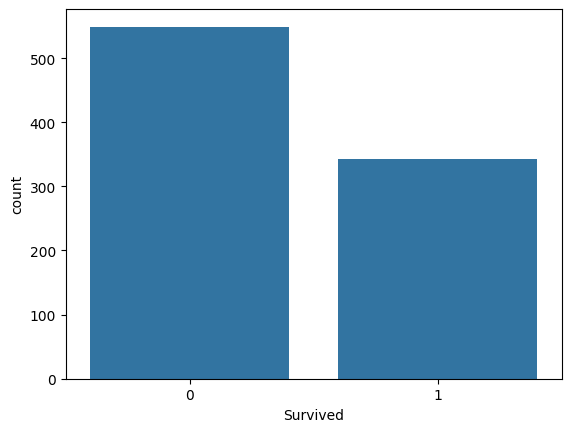

In [287]:
display(sns.countplot(x="Survived", data=data))

In [288]:
# Elimina filas con nulos
data.drop("Cabin", axis=1, inplace=True)  # Muchos nulos en la columna
data = data.dropna()

### Usa variables _dummy_ para representar las clases

In [289]:
display(pd.get_dummies(data["Sex"]))

,female,male
0,False,True
1,True,False
2,True,False
3,True,False
4,False,True
...,...,...
885,True,False
886,False,True
887,True,False
889,False,True


In [290]:
data_sexo = pd.get_dummies(data["Sex"], drop_first=True)
display(data_sexo)

,male
0,True
1,False
2,False
3,False
4,True
...,...
885,False
886,True
887,False
889,True


In [291]:
data = pd.concat([data, data_sexo], axis=1)

### Se transforman booleanos a enteros

In [292]:
for col in ["male"]:
    data[col] = data[col].astype(int)

### Se seleccionan algunas columnas para el ejempo

In [293]:
data.drop(["Name", "Ticket", "Sex", "Embarked"], axis=1, inplace=True)

In [294]:
display(data.head())

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male
0,1,0,3,22.0,1,0,7.2500,1
1,2,1,1,38.0,1,0,71.2833,0
2,3,1,3,26.0,0,0,7.9250,0
3,4,1,1,35.0,1,0,53.1000,0
4,5,0,3,35.0,0,0,8.0500,1


## Partición de los datos

Se reserva un subconjunto de test.

In [295]:
y_data = data["Survived"]

x_data = data.drop("Survived", axis=1)

In [296]:
x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data, test_size=TEST_SPLIT_SIZE, random_state=RANDOM_STATE
)

## Se instancian y entrenan los modelos

#### Modelo RLO Scratch

In [297]:
import numpy as np


class RegresionLogisticaClassifierScratch:
    def __init__(self, learning_rate=0.1, n_iter=100, monitorizar_loss=False):
        self.learning_rate = learning_rate
        self.n_iter = n_iter
        self.b = 0
        self.w = None  # Se reinicializará en el método `fit`

        self._monitorizar_loss = monitorizar_loss

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        """
        Ajuste del modelo de regresión logística.

        :param X: Datos de entrada.
        :param y: Etiquetas de clase.
        """
        # Inicializar los pesos en función del número de características. Se inicializa tardíamente porque
        # necesitamos saber el número de características de los datos de entrada, cosa que no sabemos en el
        # constructor
        self.w = np.zeros(X.shape[1])

        # Iterar el número de épocas especificado
        for i in range(self.n_iter):
            # Predicción inicial: combinación lineal de los pesos y las características
            y_hat = self.__predict(X, self.w, self.b)

            # Aplica la función sigmoide para obtener probabilidades: mapear a `[0, 1]`
            sig = self.__sigmoid(y_hat)

            # Se calcula la pérdida, en este caso sólo para monitorización, si aplica
            if self._monitorizar_loss:
                loss = self.__loss(y, sig)

                # Imprimir el valor de la pérdida cada 10 iteraciones
                if (i + 1) % 10 == 0:
                    print(f"[Iter. {i+1}/{self.n_iter}] Loss = {loss}")

            # Se calculan los gradientes de los pesos y el sesgo
            grad_w = self.__dldw(X, y, sig)
            grad_b = self.__dldb(y, sig)

            # Se actualizan los pesos y el sesgo realizando un paso de gradiente descendente
            self.w = self.__update(self.w, grad_w, self.learning_rate)
            self.b = self.__update(self.b, grad_b, self.learning_rate)

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Predicción de las etiquetas de clase. Se devuelven las etiquetas predichas tras aplicar
        un umbral de 0.5 a las probabilidades.

        :param X: Datos de entrada.
        :return: Etiquetas de clase predichas.
        """
        # Predicción inicial: combinación lineal de los pesos y las características
        y_hat = self.__predict(X, self.w, self.b)

        # Aplica la función sigmoide para obtener probabilidades: mapear a `[0, 1]`
        probs = self.__sigmoid(y_hat)

        # Umbraliza las probabilidades para obtener las etiquetas de clase, que serían 0 o 1
        return (probs >= 0.5).astype(int)

    ###############################################################
    # Se incluyen las funciones desarrolladas en las celdas anteriores como métodos privados
    # de la clase. Se usan métodos estáticos por conveniencia, ya que no se necesita acceder
    # a los atributos de la clase, que se pasan como argumentos a los métodos

    @staticmethod
    def __predict(X, w, b):
        """
        Predicción: combinación lineal de los pesos y las características.

        :param X: Datos de entrada.
        :param w: Pesos.
        :param b: Sesgo.
        :return: Predicciones lineales.
        """
        return np.dot(X, w) + b

    @staticmethod
    def __sigmoid(y_hat):
        """
        Función sigmoide para mapear valores a probabilidades en el rango `[0, 1]`.

        :param y_hat: Predicción lineal.
        :return: Valores transformados a probabilidades.
        """
        # Se limitan los valores de `y_hat` para evitar desbordamiento en la exponencial
        y_hat = np.clip(y_hat, -500, 500)

        return 1 / (1 + np.exp(-y_hat))

    @staticmethod
    def __loss(y, sigmoid):
        """
        Función de pérdida logística.

        :param y: Etiquetas verdaderas.
        :param sigmoid: Predicciones probabilísticas.
        :return: Pérdida promedio (escalar).
        """
        # Se limitan los valores de `sigmoid` para evitar errores en el cálculo
        sigmoid = np.clip(sigmoid, 1e-15, 1 - 1e-15)

        return -(y * np.log(sigmoid) + (1 - y) * np.log(1 - sigmoid)).mean()

    @staticmethod
    def __dldw(X, y, sigmoid):
        """
        Gradiente de la pérdida con respecto a los pesos.

        :param X: Datos de entrada.
        :param y: Etiquetas verdaderas.
        :param sigmoid: Predicciones probabilísticas.
        :return: Gradiente de los pesos.
        """
        return np.dot(X.T, (sigmoid - y)) / X.shape[0]

    @staticmethod
    def __dldb(y, sigmoid):
        """
        Gradiente de la pérdida con respecto al sesgo.

        :param y: Etiquetas verdaderas.
        :param sigmoid: Predicciones probabilísticas.
        :return: Gradiente del sesgo.
        """
        return (sigmoid - y).mean()

    @staticmethod
    def __update(a, g, lr):
        """
        Actualiza el valor de los pesos o el sesgo usando gradiente descendente.

        :param a: Valor actual.
        :param g: Gradiente.
        :param lr: Tasa de aprendizaje.
        :return: Valor actualizado.
        """
        return a - (g * lr)


#### Modelo RLO Scikit-learn

In [298]:
from sklearn.linear_model import LogisticRegression
modelo_rlo_scikit = LogisticRegression()

#### Modelo SVM de Scikit-learn

In [299]:
from sklearn.svm import SVR
modelo_svm = SVR()

In [300]:
modelo_rlo_scratch =  RegresionLogisticaClassifierScratch()

In [301]:
modelos = [modelo_svm, modelo_rlo_scikit,modelo_rlo_scratch ]
for modelo in  modelos:
    modelo.fit(x_train, y_train)



d:\Users\O M E N\miniconda3\envs\conda_env\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Evaluación del modelo

En este caso se mide la **precisión** del modelo.

In [302]:
from sklearn.metrics import classification_report, accuracy_score
def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

Debemos usar la función round para convertir los valores continuos a etiquetas binarias 0 o 1. EN modelos como el SVM o regresión lgística, se necesita redondear las predicciones a clases binarias

In [303]:
for modelo in modelos: 
    preds = modelo.predict(x_test)
    preds = preds.round()  
    # Accuracy score and classification report
    print(f"Test accuracy: {round(accuracy_score(y_test, preds)*100)} %.")
    print(classification_report(y_test, preds))

Test accuracy: 67 %.
              precision    recall  f1-score   support

           0       0.65      0.99      0.78       129
           1       0.94      0.18      0.30        85

    accuracy                           0.67       214
   macro avg       0.79      0.58      0.54       214
weighted avg       0.76      0.67      0.59       214

Test accuracy: 78 %.
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       129
           1       0.73      0.68      0.71        85

    accuracy                           0.78       214
   macro avg       0.77      0.76      0.76       214
weighted avg       0.77      0.78      0.77       214

Test accuracy: 60 %.
              precision    recall  f1-score   support

           0       0.60      0.99      0.75       129
           1       0.50      0.01      0.02        85

    accuracy                           0.60       214
   macro avg       0.55      0.50      0.39       214
weighted av

## Contraste de modelos y conclusiones de los resultados

Todos los modelos tienen una precisión bastante alta en la clasificación de la clase 0, muy por encima de los valores de la clase 0.

Esto puede suceder por el desbalance en las clases, donde la clase 0 tiene muchas más muestras que la clase 1. Esto coincide con el gráfico que realizamos al principio, habiendo casi 200 muestras más de la clase 0 que de la clase 1.

El modelo **RLO de Scikit** presenta un rendimiento superior con un 78% de precisión y un F1-Score balanceado para ambas clases (0.82 para clase 0 y 0.71 para clase 1). Es decir, es el modelo que mejor equilibra la clasifiación entre las clases.

- **Clase 0**: Todos los modelos funcionan bien con la clase 0, pero el RLO-scikit es ligeramente mejor (F1-score de 0.82 frente a 0.75-0.78 en los otros).

- **Clase 1**: El RLO-scikit tiene un rendimiento sólido con la clase 1 (F1-score de 0.71), mientras que el SVM (0.30) y el RLO-scratch (0.02) tienen dificultades significativas para clasificar correctamente esta clase.

